<a href="https://colab.research.google.com/github/fkonrad97/Network/blob/main/routingtable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import csv
import pandas as pd
import numpy as np
import networkx as nx
import random
import math
from scipy.stats import entropy
import matplotlib.pyplot as plt

# I/O

In [38]:
# Read positions of nodes (X,Y,Z)

def positionRead(name):
    positions = pd.read_csv(name + ".csv", header=None, sep=";")
    # Remove a plus sign from the end of the number
    positions[0][0] = positions[0][0][:-1]
    positions[0] = positions[0].astype(float)    # Convert data to numerical value
    return positions

In [39]:
# Read connection table between nodes

def connectionRead(name):
    connections = pd.read_csv(name + ".csv", header=None)
    return connections

In [40]:
# List of the positions of nodes
# positions = positionRead("Network/Brain_data/Brain1Positions")
positions = positionRead("/content/Brain1Positions")

# List of how nodes connected to each other
# connections = connectionRead("Network/Brain_data/Brain1Connections")
connections = connectionRead("/content/Brain1Connections")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Additional Methods

In [41]:
# Calculate distance between 2 points in Euclidean space
# Positions should be 3D (X,Y,Z)

def Euclidean_dist(p1, p2):
    point1 = np.array((positions[0][p1], positions[1][p1], positions[2][p1]))
    point2 = np.array((positions[0][p2], positions[1][p2], positions[2][p2]))
    return np.linalg.norm(point1 - point2)

In [100]:
def Euclidean_dist2D(p1, p2):
    point1 = np.array((p1[0], p1[1]))
    point2 = np.array((p2[0], p2[1]))
    return np.linalg.norm(point1 - point2)

In [86]:
def hyperbolicDist(coord1, coord2):
  x1 = coord1[0]
  y1 = coord1[1]
  x2 = coord2[0]
  y2 = coord2[1]

  return np.arccosh(np.cosh(y1)*np.cosh(x2-x1)*np.cosh(y2)-np.sinh(y1)*np.sinh(y2))

In [42]:
# Add a key-value pair to the existing dictionary

def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

In [43]:
# Returns with a dictionary. Key is the number of the node and 
# the value is the distant between the current node(act) and its neighbour.
# The list is ascendant by the distance.

def get_dist(act, neighbours):
    dist = {}
    
    for i in neighbours:
        add_element(dist, i, Euclidean_dist(act, i))
    
    dist = sorted(dist.items(), key=lambda x: x[1])
    
    return dist

In [44]:
def chooseRandomShortest(paths):
  randomPaths = []

  for i in paths:
    randomPaths.append(random.choice(i))

  return randomPaths

In [45]:
def avgEntropy(graph, routingTables):
  sum = 0

  for i in range(len(graph.nodes)):
    routingTables[i].getNextHopsList()
    sum += entropy(routingTables[i].nextHops)
  
  return (sum / len(graph.nodes))

In [46]:
def readWeightedIn():
  greedyNeighbours = []
  for i in range(len(connections)):
    for j in range(len(connections)):
       if connections[i][j] == 1 and i < j:
          dist = Euclidean_dist(i,j)
          greedyNeighbours.append([i,j,dist])
  return greedyNeighbours

In [47]:
def readUnweightedIn():
  neighbours = []
  for i in range(len(connections)):
    for j in range(len(connections)):
      if connections[i][j] == 1 and i < j:
        neighbours.append([i, j])
  return neighbours

# Graph algorithms

In [48]:
def findPaths(src, graph):
  paths = []

  for j in range(len(graph.nodes)):
    if src!=j:
      path = [p for p in nx.all_shortest_paths(graph, source=src, target=j)]
      paths.append(path)
  
  return paths

In [49]:
def greedy(graph, src, dest):
  pathsGreedy = []
  pathsGreedy.append(src)
  ready = False
  act = src

  while ready==False:
    nbours = [n for n in graph.neighbors(act)]

    # Calculates the distances of the neighbour nodes from the end node
    dist = get_dist(dest, nbours)

    # if the 'dest' is connected with 'act'
    if dest in nbours:
      pathsGreedy.append(dest)
      return pathsGreedy

    # if 'act' has no neighbours 
    elif len(nbours) == 0:
      return "No neighbours"

    # if 'act' has just 1 neighbour
    elif len(neighbours) == 1:
      act = nbours[0]
      pathsGreedy.append(act)

    elif len(nbours) > 1:
      not_found = False
      for i in dist:
        if i[0] not in pathsGreedy:
          act = i[0]
          pathsGreedy.append(act)
          not_found = True
          break
      # If there are no more choosable node on the list
      if not_found == False:
        act = dist[0][0]
        pathsGreedy.append(act)

# Network Generator

In [87]:
class Network:
    def __init__(self, inputRadius):
      self.inputRadius = inputRadius
      self.xCoordinate = []
      self.yCoordinate = []
      self.coordinates = []
      self.edges = []

    def add_edge(self, src, dest):
      edge = [src, dest]
      self.edges.append(edge)

    def growNetwork(self):
      for i in range(len(self.coordinates)):
        for j in range(len(self.coordinates)):
          if self.coordinates[i] != self.coordinates[j]:
            dist = hyperbolicDist(self.coordinates[i],self.coordinates[j])
            if dist < self.inputRadius:
              self.add_edge(i,j)

    def generatePoint(self):
      radius = self.inputRadius * math.sqrt(random.random())
      theta = 2 * math.pi * random.random()

      return radius * math.cos(theta), radius * math.sin(theta)

    def createNodes(self, n):
      self.xCoordinate, self.yCoordinate =  [], []
      for i in range(n):
          xc, yc = self.generatePoint()
          self.xCoordinate.append(xc)
          self.yCoordinate.append(yc)
      self.convertCoords(n)

    def convertCoords(self, n):
        for i in range(n):
           self.coordinates.append([self.xCoordinate[i], self.yCoordinate[i]])

    def plot(self):
        plt.figure(1)
        plt.plot(self.xCoordinate, self.yCoordinate,'b.')
        plt.grid('on')

        x_circle = [self.inputRadius*math.cos(i) for i in np.arange(0, math.pi*2, 0.01)]
        y_circle = [self.inputRadius*math.sin(i) for i in np.arange(0, math.pi*2, 0.01)]
        plt.plot(x_circle, y_circle, '-k')

# Classes

In [149]:
class Graph():
  def __init__(self,):
    self.G = nx.Graph()
    self.nodes = self.G.nodes

  def addWeightedEdges(self):
    neighborList = readWeightedIn()
    for i in neighborList:
      self.G.add_edge(i[0], i[1], weight=i[2])

  def addWeightedNetworkEdges(self, network):
    for i in network.edges:
      self.G.add_edge(i[0], i[1], weight=Euclidean_dist2D(network.coordinates[i[0]],network.coordinates[i[1]]))

  def addUnweightedEdges(self):
    neighborList = readUnweightedIn()
    for i in neighborList:
      self.G.add_edge(i[0],i[1])

In [150]:
class routingTable():

  def __init__(self, nodeID, graph):
    self.graph = graph.G
    self.nodeID = nodeID
    self.table = []
    self.nextHops = []

  def addtoTable(self, dest, nextHop):
    self.table.append([dest, nextHop])

  def findNextHop(self):
    paths = findPaths(self.nodeID, self.graph)
    paths = chooseRandomShortest(paths)
    for i in paths:
      self.addtoTable(i[-1], i[1])

  def findNextHopGreedy(self):
    paths = []
    for i in range(len(self.graph.nodes)):
      if self.nodeID!=i:
        paths.append(greedy(self.graph, self.nodeID, i))
    for i in paths:
      self.addtoTable(i[-1], i[1])

  def getNextHopsList(self):
    self.nextHops = []
    for i in self.table:
      self.nextHops.append(i[1])

# **GREEDY ALGORITHM**

In [186]:
Ggreedy = Graph()
Ggreedy.addWeightedEdges()

routingTablesGreedy = []

for i in Ggreedy.nodes:
  table = routingTable(i, Ggreedy)
  table.findNextHopGreedy()
  routingTablesGreedy.append(table)

In [187]:
entropyGreedyValue = avgEntropy(Ggreedy, routingTablesGreedy)
entropyGreedyValue

4.24936333658451

# **RANDOM UNWEIGHTED**

In [151]:
G = Graph()
G.addUnweightedEdges()

In [152]:
# Each nodes' routing table
routingTables = []

for j in range(10):
  routingtable = []
  for i in range(len(G.nodes)):
    table = routingTable(i,G)
    table.findNextHop()
    routingtable.append(table)
  routingTables.append(routingtable)

In [153]:
entropyList = []

for i in routingTables:
  entropyList.append(avgEntropy(G, i))

In [154]:
entropyList

[4.247159897923012,
 4.243380647231356,
 4.245625983444261,
 4.2454031474109035,
 4.250961701933616,
 4.244489160037206,
 4.249741906662836,
 4.2444784823750865,
 4.245301248842816,
 4.2479182219173826]

# **KRIUKOV GRÁFGENERÁLÁS**

[[-0.5686444381745462, 0.37952928776694433], [0.2774210542579096, -0.31182772653373114], [0.17718531658395575, -0.30871828225027576], [0.8379180614063796, 0.4521893047840277], [-0.5468903529701604, 0.20856766872897925], [-0.6358911321889024, -0.5198033918637169], [0.21255252688297827, 0.9100643691417764], [0.6591606169002875, 0.6988007917573803], [-0.6799259206824967, -0.4479248770596952], [0.6731591002976489, -0.34285824586968566], [0.6691002379332474, -0.3105328002416141], [0.40869989229749554, -0.3515155130504631], [0.4225685909430719, 0.43479861446916374], [-0.5385532734436975, -0.6942612931761671], [0.2450797629278301, -0.8038247240074735], [-0.004497872122935887, -0.7544474772257689], [0.17356857617835153, 0.4556811554789305], [-0.00573226055046138, 0.9382401009580911], [-0.3075264341871765, 0.16344791704731262], [-0.5058564634615792, 0.8111406289500614], [-0.7486007020893993, -0.3379492879467924], [0.34286879521566777, -0.9371889556418636], [-0.8733746434576418, -0.0622396938490

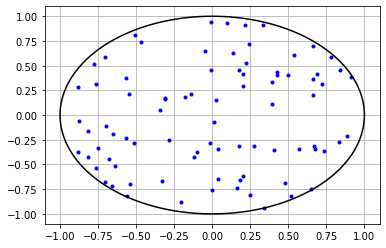

In [97]:
# Generate network

network = Network(1)
network.createNodes(83)
network.growNetwork()
network.plot()

In [123]:
GKriukov = Graph()
GKriukov.addWeightedEdges(network)

EdgeView([(0, 4), (0, 5), (0, 8), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 22), (0, 24), (0, 25), (0, 26), (0, 27), (0, 29), (0, 30), (0, 34), (0, 35), (0, 36), (0, 38), (0, 43), (0, 45), (0, 46), (0, 49), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 61), (0, 65), (0, 67), (0, 68), (0, 69), (0, 71), (0, 74), (0, 76), (0, 79), (0, 82), (4, 1), (4, 2), (4, 5), (4, 8), (4, 13), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 22), (4, 24), (4, 25), (4, 26), (4, 27), (4, 29), (4, 30), (4, 34), (4, 35), (4, 36), (4, 38), (4, 42), (4, 43), (4, 46), (4, 49), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (4, 59), (4, 61), (4, 63), (4, 65), (4, 67), (4, 68), (4, 69), (4, 70), (4, 74), (4, 76), (4, 78), (4, 79), (4, 80), (4, 82), (5, 2), (5, 8), (5, 13), (5, 15), (5, 18), (5, 20), (5, 22), (5, 23), (5, 24), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 33), (5, 34), (5, 36), (5, 38), (5, 39), (5, 47), (5, 49), (5, 50), (5, 53), (5, 54), 

### **Random Kriukov**

In [124]:
# Each nodes' routing table
routingTablesKriukov = []

for j in range(10):
  routingtable = []
  for i in range(len(GKriukov.nodes)):
    table = routingTable(i,GKriukov)
    table.findNextHop()
    routingtable.append(table)
  routingTablesKriukov.append(routingtable)

In [125]:
entropyListKriukov = []

for i in routingTablesKriukov:
  entropyListKriukov.append(avgEntropy(GKriukov, i))

In [126]:
entropyListKriukov

[4.2260551683159155,
 4.217967895723957,
 4.222908947232048,
 4.218483775790944,
 4.217144938884035,
 4.219045220897811,
 4.222391673302572,
 4.217526623345642,
 4.222158693035132,
 4.218294506586456]

### Greedy Kriukov

In [190]:
routingTablesGreedyKriukov = []

for i in GKriukov.nodes:
  table = routingTable(i, GKriukov)
  table.findNextHopGreedy()
  routingTablesGreedyKriukov.append(table)

In [191]:
entropyGreedyKriukovValue = avgEntropy(GKriukov, routingTablesGreedyKriukov)
entropyGreedyKriukovValue

4.214624288585639